# TASK 1 - Build a function that converts a labelled dataset into labelled and unlabelled subsets.

The function uses sklearn's train_test_split function. This function guarantees that there is at least one element of each class in the resulting split. The X values input to the split function are the indices of the labels. The indices and labels are all returned by the function.

In [180]:
from random import choice
import numpy as np
from sklearn.model_selection import train_test_split

# proportion represents the how much of the dataset should be unlabelled
def getLabelledAndUnlabelledSubsets(dataset_labels, proportion):
    indices = list(range(len(dataset_labels)))
    index_labelled, index_unlabelled, y_labelled, y_unlabelled = train_test_split(indices, 
                                                                                  dataset_labels, test_size = proportion)
    return (index_labelled, index_unlabelled, y_labelled, y_unlabelled)

# DEMO
sampleLabels = [1,1,2,2,3,3,1,2,3]
proportion = 0.5
(index_labelled, index_unlabelled, y_labelled, y_unlabelled) = getLabelledAndUnlabelledSubsets(sampleLabels,proportion)

print("Sample labels: " + str(sampleLabels))
print("Indices of labels for the labelled subset: " + str(index_labelled))
print("Labels of the labelled subset: " + str(y_labelled))
print("Indices of labels for the unlabelled subset: " + str(index_unlabelled))
print("Labels of the unlabelled subset: " + str(y_unlabelled))

Sample labels: [1, 1, 2, 2, 3, 3, 1, 2, 3]
Indices of labels for the labelled subset: [1, 7, 6, 4]
Labels of the labelled subset: [1, 2, 1, 3]
Indices of labels for the unlabelled subset: [0, 3, 2, 8, 5]
Labels of the unlabelled subset: [1, 2, 2, 3, 3]


# TASK 2 - Data cleaning

Image data expected in the 'carData' folder. This function uses os.listdir to get a list of the files in the folder. It then iterates through the files and checks the dimentions of the image (the shape of the numpy object). Images that don't have three channels are deleted. A list of the names of the files that have been deleted are returned (in case that information is needed).

In [75]:
import numpy as np
import matplotlib.image as mpimg
import os

def cleanImages(path):
    files = os.listdir(path)
    filesRemoved = list()
    for file in files:
        imagePath = os.path.join(path, file)
        image = mpimg.imread(imagePath)
        shape = np.shape(image)
        if (len(shape) != 3):
            filesRemoved.append(file)
            os.remove(imagePath)
        else:
            (_,_,numChannels) = shape
            if numChannels != 3:
                filesRemoved.append(file)
                os.remove(imagePath)
    return filesRemoved

# DEMO
trainPath = 'cars_train/'
print("Number of labelled images after cleaning: " + str(len(os.listdir(trainPath))))

Number of labelled images after cleaning: 8126


# TASK 3 - Dataset representation

Load the mat file with the labels, then load resnet18 and change the last layer to an Identity layer.

Next, iterate through the files and build the dictionary, as defined.
Finally, the model is saved to the 'task3Dict.pt' file

NOTE: The mat file README said that the mat file should have several parameters for each image. This was not found to be accurate. Instead I found the train_perfect_preds.txt file and assumed that these were the class labels.

In [65]:
import torch
import torch.nn.modules.linear
from PIL import Image
import torchvision.transforms.functional as TF
import os
from os import path
import json

def loadData(labelledImagePath, labelPath):
    labels = [int(line.strip()) for line in open(labelPath, 'r')]
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    model.fc = torch.nn.Identity()
    dataset = {} 
    files = os.listdir(labelledImagePath)
    i = 0
    for file in files:
        imagePath = os.path.join(labelledImagePath, file)
        image = Image.open(imagePath)
        x = TF.to_tensor(image)
        x.unsqueeze_(0) # Set batch size to 1, only 1 image (dummy dimention)
        with torch.no_grad():
            embed = model(x)
        embed = embed.squeeze(0) # Remove dummy dimention
        currentImageDict = {}
        currentImageDict['embedding'] = embed
        imageIndex = files[i].split(".")[0]
        currentImageDict['class_idx'] = labels[int(imageIndex)]
        currentImageDict['labelled'] = True
        dataset[i] = currentImageDict
        i = i + 1
    dictFileName = 'task3Dict.pt'
    torch.save(dataset, dictFileName)
    return

labelledImagePath = 'C:/Users/Patrick/Documents/GitHub/statsCanExam/cars_train/'
labelPath = 'C:/Users/Patrick/Documents/GitHub/statsCanExam/devkit/train_perfect_preds.txt'
loadData(labelledImagePath, labelPath)
print("Task 3 model file saved")

Using cache found in C:\Users\Patrick/.cache\torch\hub\pytorch_vision_v0.10.0


Task 3 model file saved


# TASK 4 - Build a partially labelled dataset

Using the function from Task 1, and the processed dataset from Task 3, create a dataset with only 40% of the data being labelled, and 60% unlabelled. 

In [219]:
dataset = torch.load('task3Dict.pt')
indices = list(dataset.keys())
proportion = 0.6
(index_labelled, index_unlabelled, y_labelled, y_unlabelled) = getLabelledAndUnlabelledSubsets(indices, proportion)

for index in index_unlabelled:
    dataset[index]['labelled'] = False

print("# labelled elements: " + str(len(index_labelled)))
print("# unlabelled elements: " + str(len(index_unlabelled)))
print("Testing proportion: " + str(len(index_unlabelled) / len(dataset.keys())))
print("Task 4 complete, " + str(len(dataset.keys())) + " elements")

# labelled elements: 3250
# unlabelled elements: 4876
Testing proportion: 0.6000492247108048
Task 4 complete, 8126 elements


# TASK 5 - Create train/validation split

Create a function that takes two arguments, dataset_inputs and dataset_labels, and a float between [0,1], “training_proportion”. This function will take a dataset (inputs and labels) and split it into training and validation by the training_proportion. The function returns 4 objects, training_inputs, training_labels, test_inputs, test_labels.

Solution: Simply use train_test_split from scikit learn. Note that scikit learn uses a test size instead of a training propostion. Test size = 1 - training proportion

In [220]:
def getTrainingProportion(dataset_inputs, dataset_labels, training_proportion):
    training_inputs, test_inputs, training_labels, test_labels = train_test_split(dataset_inputs, 
                                                                                  dataset_labels,
                                                                                  test_size = 1-training_proportion)
    return (training_inputs, training_labels, test_inputs, test_labels)

# TASK 6 - Create experiment(s) to convince clients that more labelled data will improve model performance

Do a train and validate with a small labelled set and another with a larger labelled set.

Although a larger labelled data set should result in better performance, this is not what we are seeing. I am suspicious of the labels as they were not structured as specified in the dataset documentation.

Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...
Training...
Testing...


[Text(0.5, 0, 'training_proportions'),
 Text(0, 0.5, 'accuracy'),
 Text(0.5, 1.0, 'More labeled data results in better accuracy, when testes with the training data')]

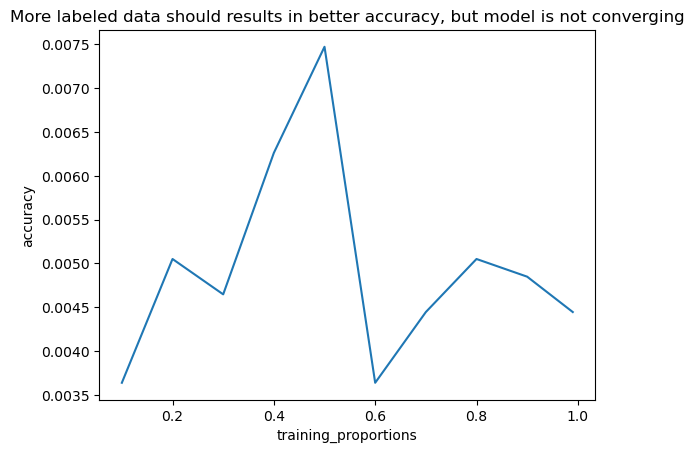

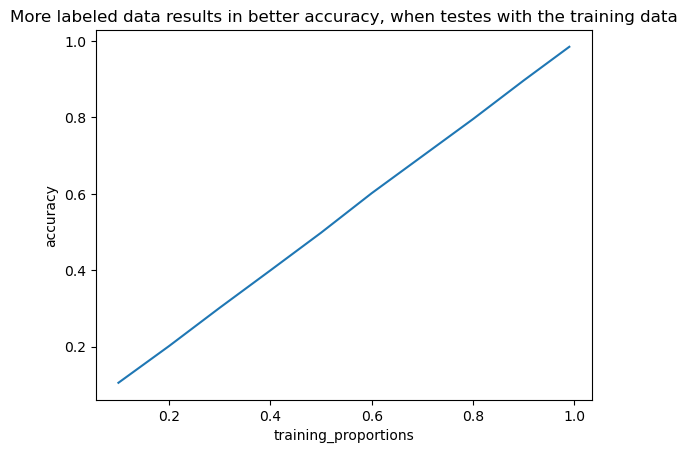

In [225]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

def loadLabelledData(dataset):
    dataset_inputs = list()
    dataset_labels = list()
    for key in dataset.keys():
        currentElement = dataset[key]
        if currentElement['labelled']:
            dataset_inputs.append(currentElement['embedding'].numpy())
            dataset_labels.append(currentElement['class_idx'])
    return (dataset_inputs, dataset_labels)

def get_SGD_accuracy(training_proportion, training_inputs, training_labels, testing_inputs, testing_labels):
    
    if training_proportion < 1:
        (training_inputs, training_labels, _, _) = getTrainingProportion(training_inputs, training_labels, training_proportion)
    X = np.array(training_inputs)
    Y = np.array(training_labels)

    print("Training...")
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, loss = 'modified_huber')) # loss chosen for predict_proba to work
    clf.fit(X, Y)

    X = np.array(testing_inputs)
    Y = np.array(testing_labels)
    
    print("Testing...")
    accuracy = clf.score(X, Y)
    
    return(accuracy, clf)


(dataset_inputs, dataset_labels) = loadLabelledData(dataset)

# Seperate a training and validation data set - always 20 percent for a hold out test
validationProportion = 0.2
(training_inputs, training_labels, testing_inputs, testing_labels) = getTrainingProportion(dataset_inputs,
                                                                                           dataset_labels,
                                                                                           validationProportion)

accuracies = list()
training_proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for training_proportion in training_proportions:
    (currentAccuracy, _) = get_SGD_accuracy(training_proportion, training_inputs, training_labels, testing_inputs, testing_labels)
    accuracies.append(currentAccuracy)

fig, ax = plt.subplots()
ax.plot(np.array(training_proportions), np.array(accuracies))
ax.set(xlabel='training_proportions', ylabel='accuracy', title='More labeled data should results in better accuracy, but model is not converging')

accuracies = list()
training_proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for training_proportion in training_proportions:
    (currentAccuracy, _) = get_SGD_accuracy(training_proportion, training_inputs, training_labels, training_inputs, training_labels)
    accuracies.append(currentAccuracy)

fig, ax = plt.subplots()
ax.plot(np.array(training_proportions), np.array(accuracies))
ax.set(xlabel='training_proportions', ylabel='accuracy', title='More labeled data results in better accuracy, when testes with the training data')

# TASK 7 - Active learning to select new instances to be labelled

Your clients have agreed to label an additional 25% of the dataset (to a total of 65% of the original dataset). 

Using the model trained on 40% of the data and the unlabelled inputs, use predict_proba function of your sklearn.linear_model.SGDClassifier model to get the probability scores for each class on your unlabelled instances. Use from scipy.stats entropy to compute the entropy of the predictions for the unlabelled instances. Select the K instances with the highest entropy for labelling, where K is the remaining number of instances that will bring your total labelled dataset to 65%. This will be added to the labelled subset and will be your ‘final’ dataset.

NOTE: Since the original dataset is fully labelled, just use the true labels from the original dataset. Hence, keeping track of indices of instances will have been important for the earlier instructions. 

In [222]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from scipy.stats import entropy

def loadUnlabelledData(dataset):
    dataset_inputs = list()
    dataset_labels = list()
    indices = list()
    for key in dataset.keys():
        currentElement = dataset[key]
        if currentElement['labelled'] == False:
            dataset_inputs.append(currentElement['embedding'].numpy())
            dataset_labels.append(currentElement['class_idx'])
            indices.append(key)
    return (dataset_inputs, dataset_labels, indices)

# Setup the model
(dataset_inputs, dataset_labels) = loadLabelledData(dataset)
X = np.array(dataset_inputs)
Y = np.array(dataset_labels)
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, loss = 'modified_huber')) # loss chosen for predict_proba to work
clf.fit(X, Y)

# Get the unlabelled data
(unlabelled_inputs, _, indices) = loadUnlabelledData(dataset)

print("# Unlabelled elements" + str(len(unlabelled_inputs)))

# Get the entropies
entropies = list()
X = np.array(unlabelled_inputs)
print("Getting the probabilities")
probabilities = clf.predict_proba(X)
print("Getting the entropies")
for i in range(probabilities.shape[0]):
    entropies.append(entropy(probabilities[i]))

desiredProportion = 0.65
training_proportion = 0.4
needed = desiredProportion - training_proportion
numNewData = int(needed * len(dataset.keys()))

print("desiredProprtion: " + str(desiredProportion))
print("Needed: " + str(needed))
print("training_proportion: " + str(training_proportion))
print("len(dataset.keys(): " + str(len(dataset.keys())))
print("numNewData: " + str(numNewData))

# Go through the data elements and switch the flag to labelled
print("# Entropies: " + str(len(entropies)))
print("# new data elements needed: " + str(numNewData))
highestEntropyIndices = np.argpartition(np.array(entropies), numNewData)
for key in highestEntropyIndices:
    dataset[key]['labelled'] = True
    
print(str(numNewData) + " new elements have been marked as labelled")

# Unlabelled elements4876
Getting the probabilities
Getting the entropies
desiredProprtion: 0.65
Needed: 0.25
training_proportion: 0.4
len(dataset.keys(): 8126
numNewData: 2031
# Entropies: 4876
# new data elements needed: 2031
2031 new elements have been marked as labelled


# TASK 8 - Final model training and evaluation

You now have additional labelled data.

Using your training dataset, train a final model and then use it to evaluate your model on your hold out validation dataset. 

Explain your results and your implementation.

Q: Based on your evaluation, was the decision to label more instances a good one?
A: It's never a bad idea to get more labelled data.

Q: Report the final performance.
A: Final performance was worse than random. I am suspicious of an issue with the labels, as the loation of the labels did not match the README file in the dataset. To check this, I did try a test where I ran the same data for both training and testing and found that the model could provide a good accuracy. This meant the model was learning the data but not generalizing. Additional investigation is needed (although there is not enough time before the deadline) to better understand what is causing this issue.

In [224]:
(training_inputs, training_labels) = loadLabelledData(dataset)
(testing_inputs, testing_labels, _) = loadUnlabelledData(dataset)

print("# of training elements: " + str(len(training_inputs)))
print("# of testing elements: " + str(len(testing_inputs)))

training_proportion = 1
(finalAccuracy,_) = get_SGD_accuracy(training_proportion, training_inputs, training_labels, testing_inputs, testing_labels)

print("Final model accuracy was: " + str(finalAccuracy))

# of training elements: 6188
# of testing elements: 1938
Training...
Testing...
Final model accuracy was: 0.006707946336429308


C:\Users\Patrick\anaconda3\envs\kerasGPU\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
